# **Youtube Spam comment Detection**




Importing Libraries

In [56]:
# Install required packages and spaCy model if not already present
%pip install spacy wordcloud --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import spacy

# Download the spaCy model using Python API (Jupyter compatible)
import spacy.cli
spacy.cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")

Note: you may need to restart the kernel to use updated packages.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Load the data

In [57]:
file_path = 'Youtube-Spam-Dataset.csv'  # Update this to your local path
df = pd.read_excel('Youtube-Spam-Dataset.csv.xlsx')


In [58]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^...,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .ï»¿,PSY - GANGNAM STYLE(?????) M/V,1


**Sanity check of data**

In [59]:
df.shape

(1956, 6)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


In [61]:
df.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64

In [62]:
df.duplicated().sum()

np.int64(3)

1=spam 0=no spam

In [63]:
df['CLASS'].value_counts()

CLASS
1    1005
0     951
Name: count, dtype: int64

# Exploratory Data Anlaysis (EDA)

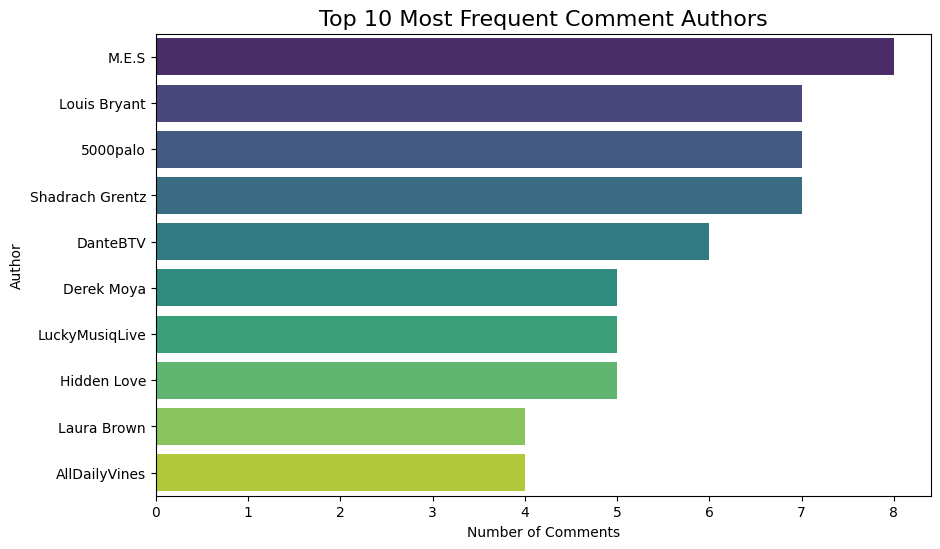

In [64]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['AUTHOR'].value_counts().head(10).values,
            y=df['AUTHOR'].value_counts().head(10).index, palette='viridis')
plt.title('Top 10 Most Frequent Comment Authors', fontsize=16)
plt.xlabel('Number of Comments')
plt.ylabel('Author')
plt.show()

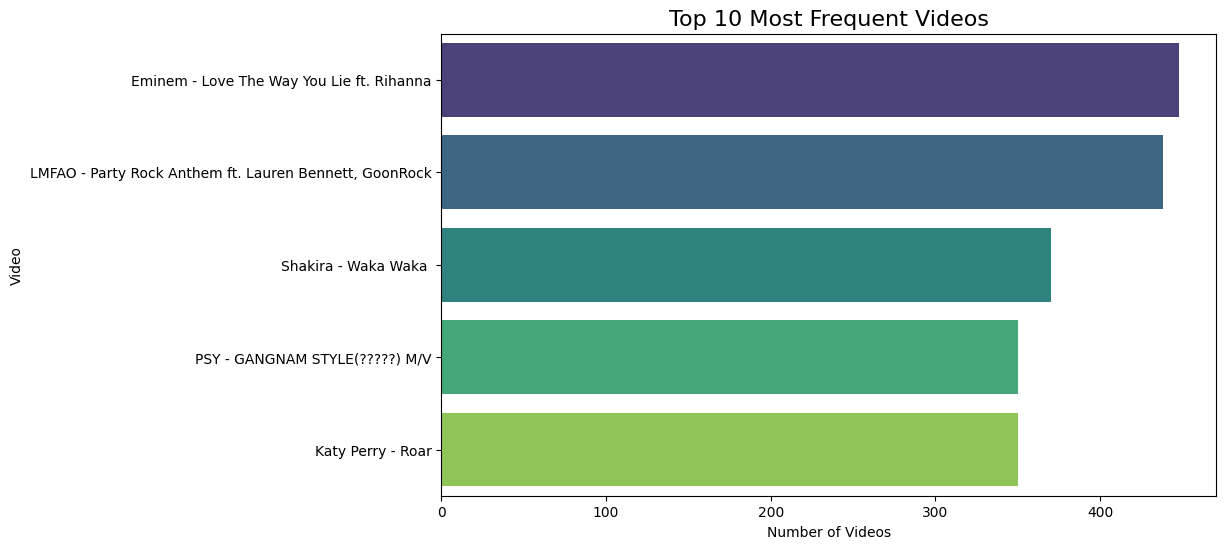

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['VIDEO_NAME'].value_counts().head(5).values,
            y=df['VIDEO_NAME'].value_counts().head(5).index, palette='viridis')
plt.title('Top 10 Most Frequent Videos', fontsize=16)
plt.xlabel('Number of Videos')
plt.ylabel('Video')
plt.show()

# What days were the most comments written?

In [66]:
df["DATE"] = df["DATE"].apply(lambda x: str(x).split('T')[0])

In [67]:
df["DATE"].value_counts().sort_values(ascending=False)[1:5]

DATE
2014-11-07    74
2014-11-08    68
2015-05-26    66
2015-05-23    59
Name: count, dtype: int64

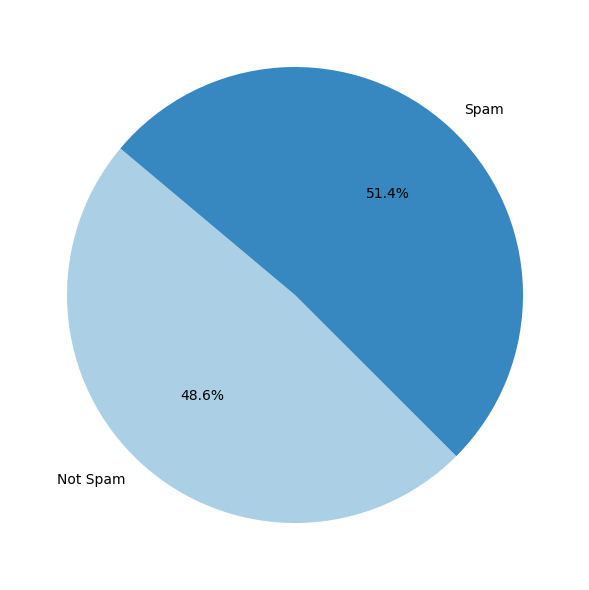

In [68]:
spam_counts = df['CLASS'].value_counts().sort_index()

palette = sns.color_palette("Blues", n_colors=len(spam_counts))
fig = plt.figure(figsize=(10, 6))
plt.pie(spam_counts, autopct='%1.1f%%', startangle=140, colors=palette, labels=["Not Spam", "Spam"])
plt.tight_layout()
plt.show()

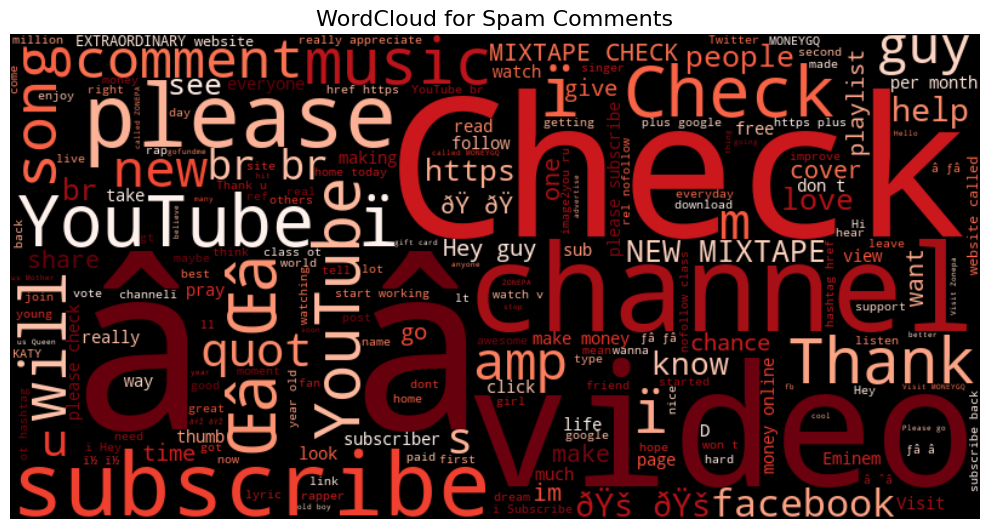

In [69]:
spam_comments = ' '.join(df[df['CLASS'] == 1]['CONTENT'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Spam Comments', fontsize=16)
plt.tight_layout()  # Adjust the layout
plt.show()

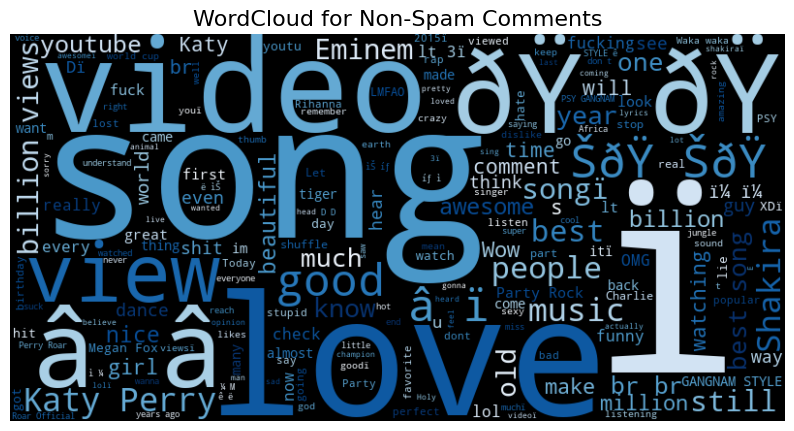

In [70]:
non_spam_comments = ' '.join(df[df['CLASS'] == 0]['CONTENT'])
non_spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(non_spam_comments)

plt.figure(figsize=(10, 6))
plt.imshow(non_spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Non-Spam Comments', fontsize=16)
plt.show()

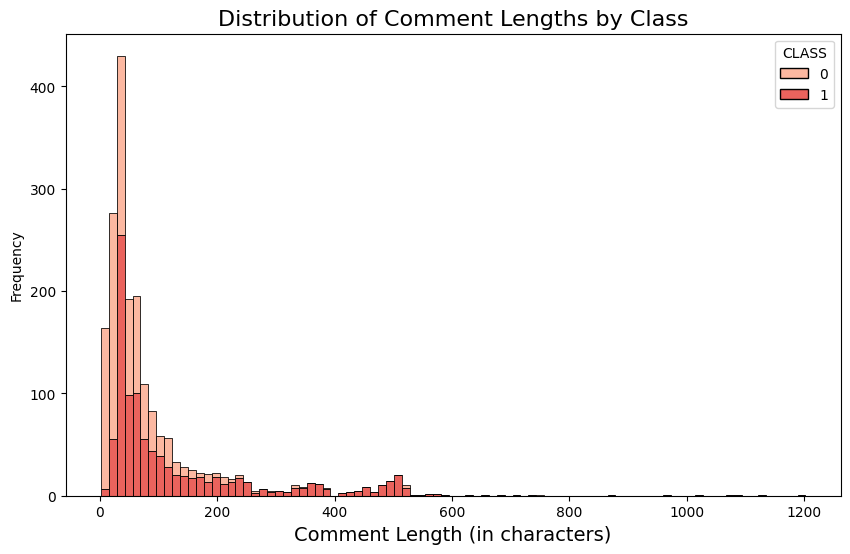

In [71]:
df['Comment Length'] = df['CONTENT'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df, x='Comment Length', hue='CLASS', multiple='stack', palette='Reds')
plt.title('Distribution of Comment Lengths by Class', fontsize=16)
plt.xlabel('Comment Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

# Dropping Columns

In [72]:
df.drop(columns=['VIDEO_NAME','COMMENT_ID'],inplace=True)

In [73]:
df.head()

,AUTHOR,DATE,CONTENT,CLASS,Comment Length
0,Julius NM,2013-11-07,"Huh, anyway check out this you[tube] channel: ...",1,56
1,adam riyati,2013-11-07,Hey guys check out my new channel and our firs...,1,166
2,Evgeny Murashkin,2013-11-08,just for test I have to say murdev.com,1,38
3,ElNino Melendez,2013-11-09,me shaking my sexy ass on my channel enjoy ^_^...,1,50
4,GsMega,2013-11-10,watch?v=vtaRGgvGtWQ Check this out .ï»¿,1,41


#Data Cleaning

In [74]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

To enhance the effectiveness of the classification process, I augmented the default stop words list in the SpaCy library and nltk with additional terms identified as frequently recurring in both spam and non-spam comments. These redundant words, considered insignificant for distinguishing between the two categories, were deemed unnecessary for the classification task.

In [76]:
stop_words=['music','youtube','video','i','u', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'so', 'keep', 'when', "'m", 'do', 'either', 'them', 'whence', 'with', 'put', '‘ve', 'on', 'your', 'becoming', 'whereby', 'whose', 'each', 'amount', 'me', 'fifteen', 'mostly', 'show', 'would', 'next',  'there', 'nothing', 'she', 'but', 'for', 'here', 'why', 'these', 'further', 'between', 'eleven', 'than', 'am', 'beside', 'after', 'under', 'if','around', 'have', 'such', 'less', 'her', 'before', 'although', 'has', 'among', 'amongst', 'least', '’re', 'should', 'fifty', 'last', 'off', 'formerly', 'until', 'much', 'this', '’ll', 'get', 'perhaps', 'how', 'eight', 'any', 'indeed', 'you', 'myself', 'neither', 'seeming', 'beforehand', 'it', 'thru', 'out', 'call', 'forty', 'one', 'still', 'whereupon', 'wherever', 'over', 'also', 'former', 'namely', 'been', 'make', 'doing', 'regarding', 'he', 'due', 'other', 'bottom', 'sometimes', 'a', 'moreover', 'though', 'whether', 'seemed', 'too', "'re", 'could', 'part', 'everything', 'by', 'thus', 'anyway', 'into', 'go', 'nevertheless', 'anyhow', 'within', 'whoever', 'third', 'being', 'various', 'wherein', 'at', 'take', 'thereby', 'does', 'nine','what', 'almost', 'ever', 'my', 'name', 'yours', 'hereby', 'say', 'hereupon', 'and', 'twelve', 'becomes', 'about', 'own', '’m', 'beyond', 'just', 'above', 'full', 'very', 'besides', 'had', 'noone', 'anything', 'both', 'down', 'whenever', 'several', 'afterwards', 'are',  'because', 'might', 'upon', 'quite', 'done', 'to', 'top', 'really', 'were', 'across', 'yourself', 'others', 'only', 'anywhere', 'move', 'whatever', 'their', 'therein', 'everyone', 'everywhere', 'now', 'something', 'toward', 'however', 'see', 'alone', "'s", '’ve', 'its', 'back', 'our', 'itself', '’d', 'every', 'thereafter', 'whom', 'already', 'as', 'hers', 'where','behind', 'in', 'therefore', 'used', 'together', 'hereafter', 'ca', 'mine', 'many', 'else', 'onto', 'since', '’s', 'whither', 'somewhere', 'themselves', 'from', 'otherwise', 'sixty', 'twenty', 'is', 'two', 'towards', '‘s', 'ten', 'they', 'please', 'those', 'did',  'hundred', 'again', 'became', 'made', 'who', '‘re', 'herein', 'same', 'front', 'up', 'whereas', 'along', 'three', 'then', 'which', 'rather', 'via', 'empty', 'hence', 'seems', 'seem', 'was', 'well', 'meanwhile', 'someone', 'elsewhere', 'once', '‘d', 'the', 'latterly', 'using', 'sometime', 'some', 'whereafter', 'six', 'while', 'of', "'d", 'first', 'herself', 'us', 'be', 'we', 'become', 'often', 'i', 'all', 'another', 'side', 'five', '‘m',  'four', 'must', 'him','somehow', 'serious', "'ll", 'or', 'none', 'during', 'can', 'thence', 'through', 're', 'that', '‘ll', 'his', "'ve", 'throughout', 'always', 'may', 'give', 'will', 'whole', 'yourselves', 'latter', 'ourselves', 'nowhere', 'the', 'reupon', 'an', 'per', 'ours','day','much']

In [77]:
stop_words=set(stop_words)

In [78]:
def clean_text(text):
  text=text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = re.sub(r'\@\w+|\#','', text)
  text = re.sub(r'[^\x00-\x7F]+','', text)
  text=re.sub(r'[^a-zA-Z0-9\s]','',text)
  text=re.sub(r'\s+https\S+',' ',text)
  text=re.sub(r'\s+www\S+',' ',text)
  text=re.sub(r'\s+http\S+',' ',text)
  text=re.sub(r'\s+',' ',text)
  text=re.sub(r'\d+','',text)
  text=text.strip()
  words = nlp(text)  # noqa: F821
  words = [word.lemma_ for word in words]
  words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
  return ' '.join(words)

In [79]:
df['CONTENT']=df['CONTENT'].apply(clean_text)

In [80]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Garbage Treatment

In [81]:
df.drop_duplicates(inplace=True)

#Feature Selection

In [82]:
df["comment_info"] = df["AUTHOR"] + "  " + df["CONTENT"] + "  " + df["CONTENT"]

In [83]:
X = df["comment_info"]
y = df["CLASS"]

#Encoding

In [84]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(X)

In [85]:
X.shape

(1925, 5735)

#Train Test Split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Building (Multinomial Naive Bayes)

In [87]:
# Define the pipeline with TfidfVectorizer and MultinomialNB
model = make_pipeline(MultinomialNB())

# Train the model using the original text data (X) and labels (y)
model.fit(X_train, y_train)

Pipeline(steps=[('multinomialnb', MultinomialNB())])

#Evaluation

In [88]:
y_pred = model.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       190
           1       0.92      0.88      0.90       195

    accuracy                           0.90       385
   macro avg       0.90      0.90      0.90       385
weighted avg       0.90      0.90      0.90       385



In [90]:
# Calculate the accuracy and store it in the variable 'accuracy'
accuracy = accuracy_score(y_test, y_pred)

# Now you can print it
print(f'Accuracy of the model: {accuracy}')

Accuracy of the model: 0.9012987012987013


In [91]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Precision: 0.9243243243243243, Recall: 0.8769230769230769, F1 Score: 0.9


ROC AUC Curve

ROC AUC Score: 0.9016194331983806


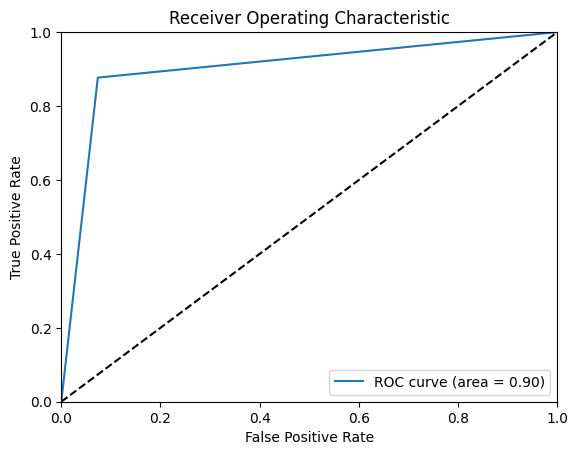

In [92]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Logistic Regression

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [94]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [96]:
# Test the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9064935064935065


In [97]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Precision: 0.9542857142857143, Recall: 0.8564102564102564, F1 Score: 0.9027027027027027


ROC AUC Curve

ROC AUC Score: 0.9071524966261808


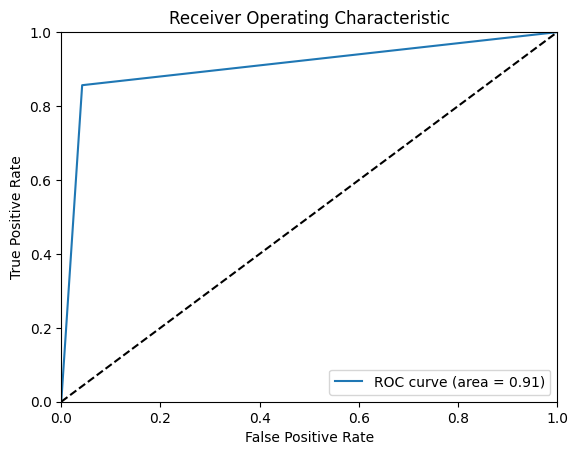

In [98]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Random Forest

In [99]:
# Import the necessary library
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier object
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))
print(f'Accuracy of Random Forest model: {accuracy_score(y_test, y_pred_rf)}')

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       190
           1       0.98      0.87      0.92       195

    accuracy                           0.92       385
   macro avg       0.93      0.93      0.92       385
weighted avg       0.93      0.92      0.92       385

Accuracy of Random Forest model: 0.9246753246753247


ROC AUC Curve

ROC AUC Score: 0.9253711201079623


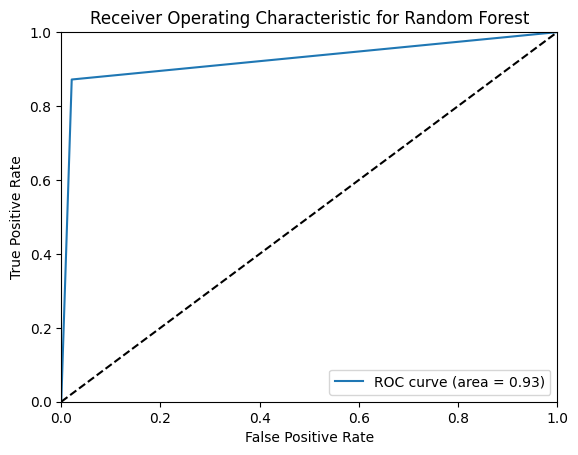

In [100]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)  # Use y_pred_rf from Random Forest
roc_auc = roc_auc_score(y_test, y_pred_rf)
print("ROC AUC Score:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()

KNN model

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [102]:
# Create a KNN classifier object
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors)

# Train the model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [103]:
# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_knn))
print(f'Accuracy of KNN model: {accuracy_score(y_test, y_pred_knn)}')

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       190
           1       0.86      0.82      0.84       195

    accuracy                           0.84       385
   macro avg       0.84      0.84      0.84       385
weighted avg       0.84      0.84      0.84       385

Accuracy of KNN model: 0.8415584415584415


ROC AUC Score: 0.8418353576248313


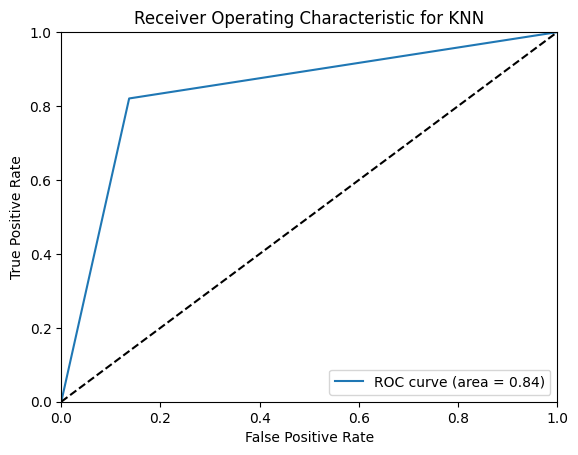

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, y_pred_knn)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

SVM Model

In [105]:
from sklearn.svm import SVC

In [106]:
# Create an SVM classifier object
svm_model = SVC(kernel='linear', probability=True)  # You can experiment with different kernels (e.g., 'rbf', 'poly')

# Train the model
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [107]:
# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_svm))
print(f'Accuracy of SVM model: {accuracy_score(y_test, y_pred_svm)}')

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       190
           1       0.96      0.87      0.91       195

    accuracy                           0.92       385
   macro avg       0.92      0.92      0.92       385
weighted avg       0.92      0.92      0.92       385

Accuracy of SVM model: 0.9168831168831169


ROC AUC Score: 0.9676653171390014


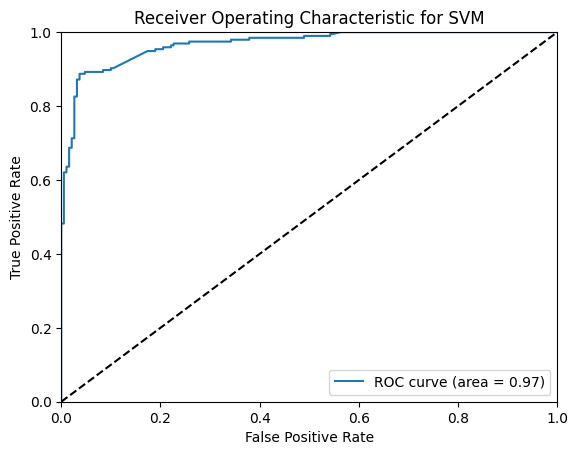

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for ROC curve
y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svm)
roc_auc = roc_auc_score(y_test, y_pred_prob_svm)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

Xg Boost

In [109]:
import xgboost as xgb

In [110]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',
    # Add other hyperparameters here
}

# Train the model
model = xgb.train(params, dtrain)

In [111]:
# Make predictions on the test set
y_pred_xgb = model.predict(dtest)

# Convert predictions to binary (0 or 1) if needed
y_pred_xgb_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_xgb]

# Evaluate the model
print(classification_report(y_test, y_pred_xgb_binary))
print(f'Accuracy of XGBoost model: {accuracy_score(y_test, y_pred_xgb_binary)}')

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       190
           1       0.98      0.82      0.89       195

    accuracy                           0.90       385
   macro avg       0.91      0.90      0.90       385
weighted avg       0.91      0.90      0.90       385

Accuracy of XGBoost model: 0.8987012987012987


ROC AUC Score: 0.9393927125506072


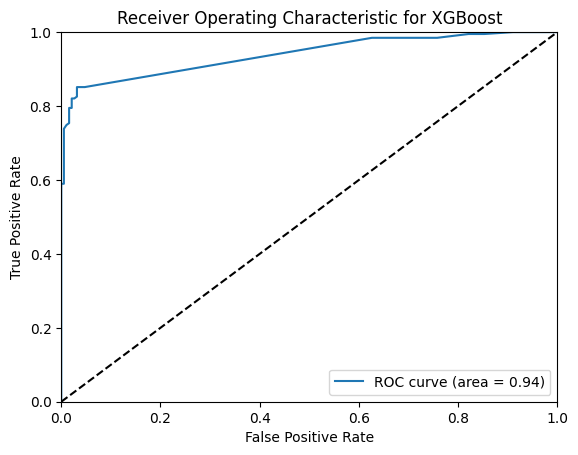

In [112]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

#**Comparison**

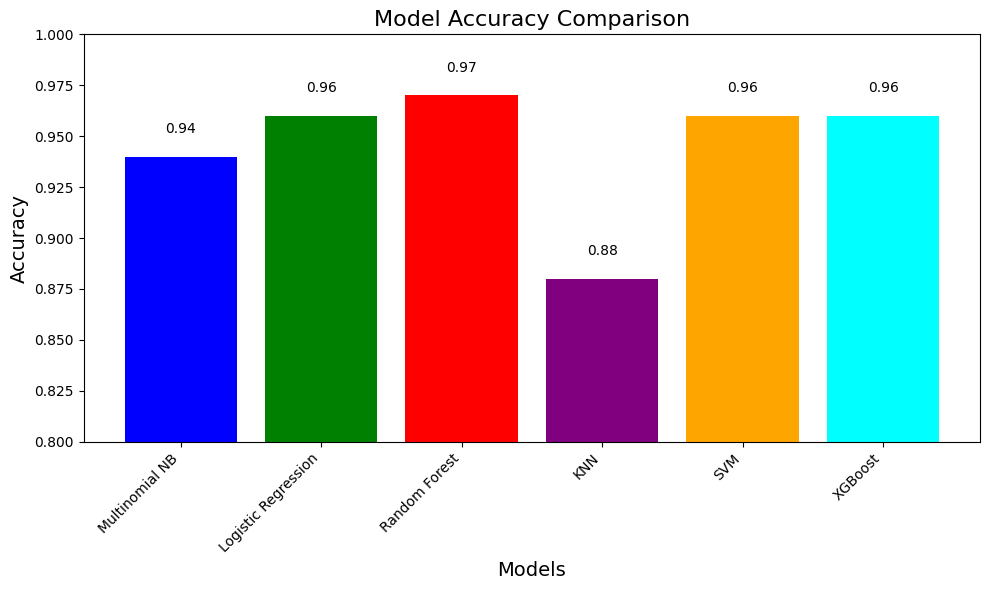

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy scores for each model (replace with your actual scores)
model_names = ['Multinomial NB', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'XGBoost']
accuracy_scores = [0.94, 0.96, 0.97, 0.88,0.96, 0.96]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.8, 1.0)  # Set y-axis limits for better visualization
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add accuracy values on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

# Display the chart
plt.show()

#F1 score Comparison

#User input

In [114]:
def predict_spam(comment):
    """Predicts whether a comment is spam or not.

    Args:
        comment: The comment text.

    Returns:
        1 if the comment is predicted to be spam, 0 otherwise.
    """
    # Clean the user input using the same function as during training
    cleaned_comment = clean_text(comment)

    # Create input features for the model
    comment_info = "Unknown Author  " + cleaned_comment + "  " + cleaned_comment
    input_features = vectorizer.transform([comment_info])

    # Make the prediction using the trained model (replace 'model' with your actual trained model)
    prediction = rf_model.predict(input_features)[0]

    return prediction

# Get user input
user_comment = input("Enter a comment: ")

# Make prediction and print the result
prediction = predict_spam(user_comment)
if prediction == 1:
    print("This comment is likely spam.")
else:
    print("This comment is likely not spam.")

This comment is likely not spam.


#**Author Detection and Prediction**

#Total Authors

In [115]:
num_authors = len(df['AUTHOR'].unique())
print(f"There are {num_authors} unique authors in the dataset.")

There are 1792 unique authors in the dataset.


#Authors appeared more than once in the dataset

In [116]:
author_counts = df['AUTHOR'].value_counts()
ununique_authors = author_counts[author_counts > 1]
num_ununique_authors = len(ununique_authors)
print(f"There are {num_ununique_authors} ununique authors in the dataset.")

There are 84 ununique authors in the dataset.


#Creating a chart to see which authors appeared more than 1 time

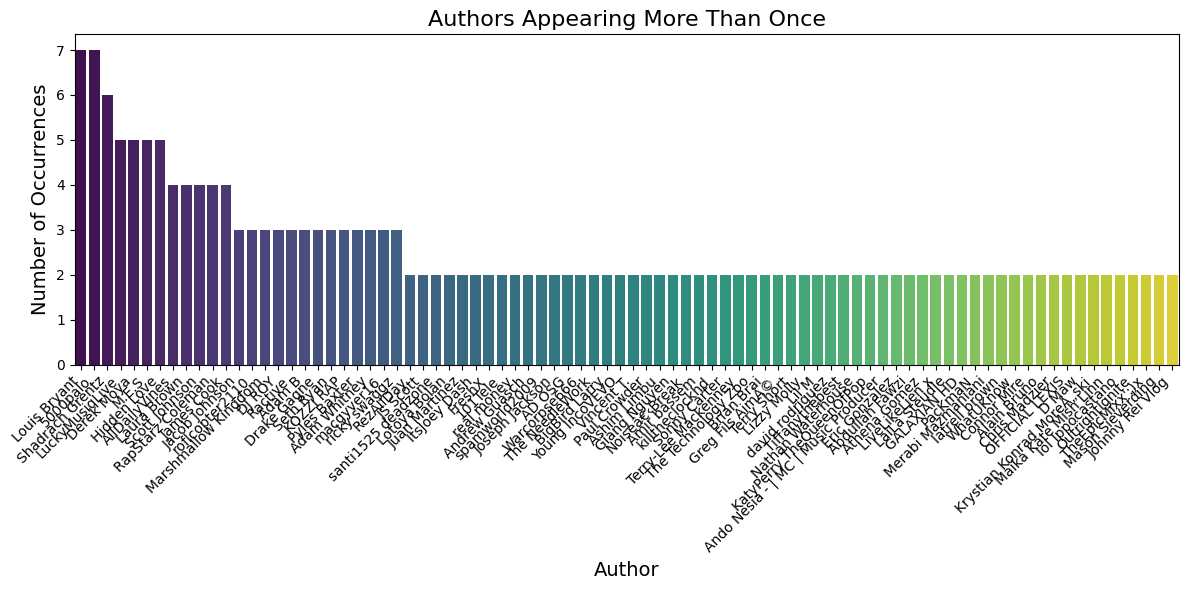

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

author_counts = df['AUTHOR'].value_counts()
ununique_authors = author_counts[author_counts > 1]

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.barplot(x=ununique_authors.index, y=ununique_authors.values, palette='viridis')
plt.title('Authors Appearing More Than Once', fontsize=16)
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#Authors who have commented same comment more than once




In [118]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has columns 'AUTHOR' and 'CONTENT'
author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]
repeated_comment_authors = author_repeated_comments['AUTHOR'].unique().tolist()

print("Authors with repeated comments:")
for author in repeated_comment_authors:
    print(author)

Authors with repeated comments:
roflcopter2110
Giang Nguyen
DJ ROY
AllDailyVines
real money
AD OSG
The NeedleWork
killtheclockhd
Greg Fils AimÃ©
Adam B
Lizzy Molly
James Cook
Merabi Mazmaniani
latrell brown
5000palo
Shadrach Grentz
Hidden Love
Adam Whitney
macgyver16
ricky swaggz


In [119]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has columns 'AUTHOR' and 'CONTENT'
author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]
num_repeated_comment_authors = len(author_repeated_comments['AUTHOR'].unique())

print(f"There are {num_repeated_comment_authors} authors with repeated comments.")

There are 20 authors with repeated comments.


# Author with the most repeated comments

In [120]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has columns 'AUTHOR' and 'CONTENT'

# Find authors with repeated comments
author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]

# Group by author and count repeated comments
author_repeat_counts = author_repeated_comments.groupby('AUTHOR')['CONTENT'].count()

# Find the author with the most repeated comments
author_with_most_repeats = author_repeat_counts.idxmax()
max_repeat_count = author_repeat_counts.max()

print(f"The author with the most repeated comments is: {author_with_most_repeats}")
print(f"They have repeated comments {max_repeat_count} times.")

The author with the most repeated comments is: 5000palo
They have repeated comments 6 times.


#Top 10 authors with most repeatated comments

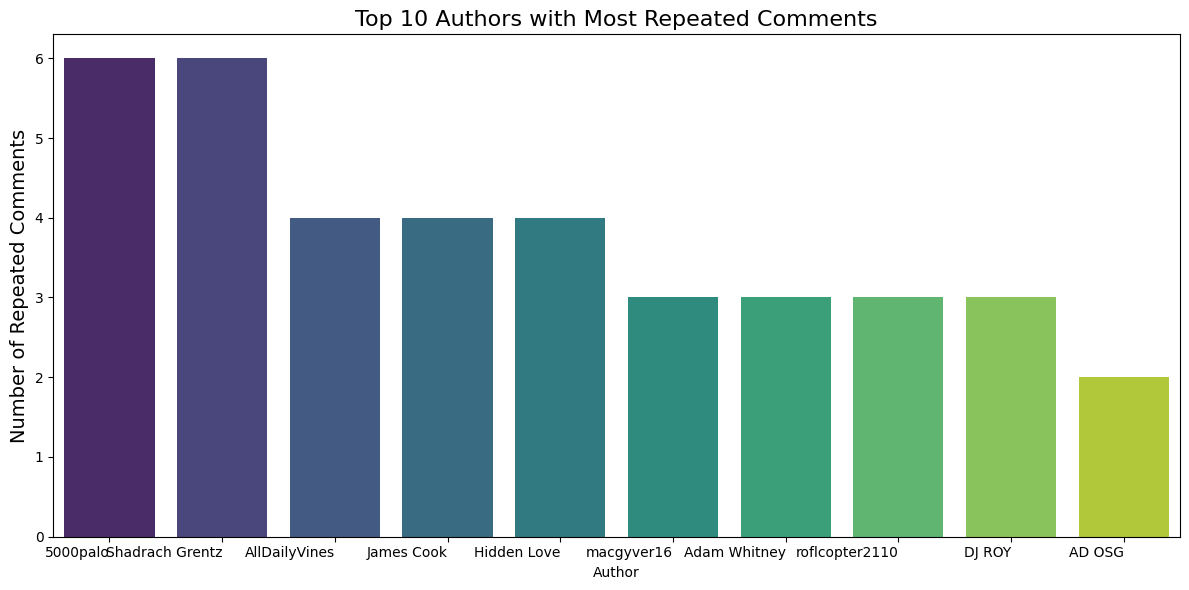

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Find authors with repeated comments
author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]

# Group by author and count repeated comments
author_repeat_counts = author_repeated_comments.groupby('AUTHOR')['CONTENT'].count()

# Get the top 10 authors with most repeated comments
top_10_authors = author_repeat_counts.sort_values(ascending=False).head(10)

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_authors.index, y=top_10_authors.values, palette='viridis')
plt.title('Top 10 Authors with Most Repeated Comments', fontsize=16)
plt.xlabel('Author', fontsize=10)
plt.ylabel('Number of Repeated Comments', fontsize=14)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#**Unauthorized Authors(repeated comments 4 or more than 4 times)**

In [122]:
import pandas as pd

# Assuming your DataFrame is named 'df' and has columns 'AUTHOR' and 'CONTENT'
author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]

# Group by author and count repeated comments
author_repeat_counts = author_repeated_comments.groupby('AUTHOR')['CONTENT'].count()

# Filter authors with 4 or more repeated comments
unauthorized_authors = author_repeat_counts[author_repeat_counts >= 4].index.tolist()

# Create the 'unauthorized' list
unauthorized = unauthorized_authors

In [123]:
print(unauthorized)

['5000palo', 'AllDailyVines', 'Hidden Love', 'James Cook', 'Shadrach Grentz']


#Making a Bar chart

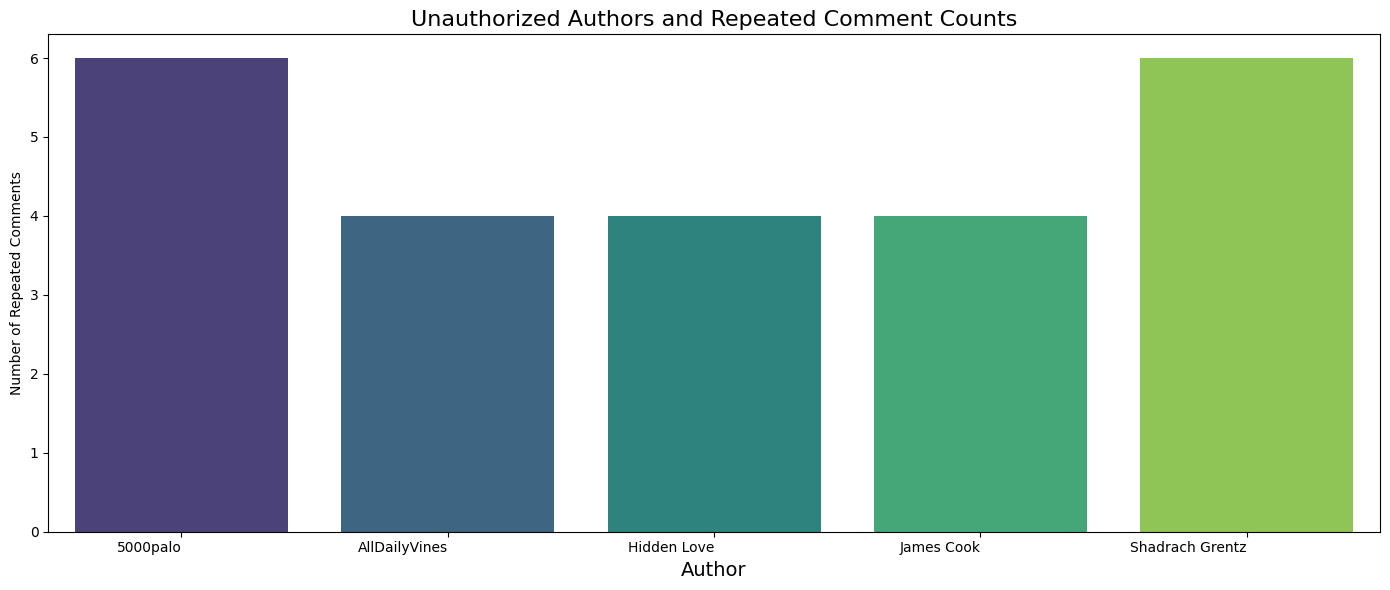

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter author_repeat_counts to include only unauthorized authors
unauthorized_repeat_counts = author_repeat_counts[author_repeat_counts.index.isin(unauthorized)]

# Create the bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x=unauthorized_repeat_counts.index, y=unauthorized_repeat_counts.values, palette='viridis')
plt.title('Unauthorized Authors and Repeated Comment Counts', fontsize=16)
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Repeated Comments', fontsize=10)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#User input system for Catching Authors with repeated comments(UNAUTHORIZED AUTHORS)

In [125]:
def catch_unauthorized_authors(comment, author):

    author_repeated_comments = df[df.duplicated(subset=['AUTHOR', 'CONTENT'], keep=False)]
    author_repeat_counts = author_repeated_comments.groupby('AUTHOR')['CONTENT'].count()
    unauthorized_authors = author_repeat_counts[author_repeat_counts >= 4].index.tolist()

    # Create input features for the model (replace 'model' with your trained model)
    comment_info = author + "  " + clean_text(comment) + "  " + clean_text(comment)
    input_features = vectorizer.transform([comment_info])

    # Check if the author is unauthorized and the comment is predicted as spam
    if author in unauthorized_authors and rf_model.predict(input_features)[0] == 1:
        return True

    return False

# Get user input for comment and author
user_comment = input("Enter a comment: ")
user_author = input("Enter the author's name: ")

# Check if the author is unauthorized
if catch_unauthorized_authors(user_comment, user_author):
    print("This author is unauthorized and their comment is flagged as spam.")
else:
    print("This comment is allowed.")

This comment is allowed.


In [126]:
import joblib

# Save trained pipeline
joblib.dump(model, 'model.pkl')

# Save list of known authors
known_authors = df['AUTHOR'].dropna().unique().tolist()
joblib.dump(known_authors, 'known_authors.pkl')


['known_authors.pkl']